# **Lane Detection**







TEAM MEMBERS:
1.  Ujwal Kothapally
2.  Venkata Krishna Sreekar Padakandla



# Install Roboflow Package

In [1]:
!pip install roboflow

# Import Dependencies

In [2]:
from IPython.display import Image, clear_output

# Install PyTorch and torchvision

In [3]:
!pip install torch
!pip install torchvision

In [4]:
#!pip install --upgrade pip

# Import PyTorch and Other Libraries

In [2]:
from roboflow import Roboflow
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim

# Downloads a dataset from Roboflow using the YOLOv5 model format, specifying the API key, project name and version, and saves it

In [3]:
rf = Roboflow(api_key="aJ3Qo0kyqheDC6TpzDW0", model_format="yolov5")
dataset = rf.workspace().project("lane-detection-xyuzw").version(1).download(location="/Downloads")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /Downloads in yolov5pytorch:: 100%|████████████████| 58/58 [00:00<00:00, 1724.90it/s]


# Custom PyTorch dataset class (CustomDataset) that wraps around the ImageFolder class, allowing for **customization of the data loading process, sets a seed for reproducibility, defines image transformations

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

# Set seed for reproducibility
torch.manual_seed(42)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset
dataset = CustomDataset(root_dir="/Downloads", transform=transform)

# Custom PyTorch neural network model (LaneDetectionModel) based on the DeepLabV3 architecture with a ResNet-101 backbone, loads pre-trained weights, and modifies the output layer to suit the task of lane detection by changing the number of output classes.

In [5]:
class LaneDetectionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(LaneDetectionModel, self).__init__()

        # Load pre-trained DeepLabV3 model
        self.deeplabv3 = models.segmentation.deeplabv3_resnet101(pretrained=True)
    
        # Modify the output layer based on your needs
        in_channels = self.deeplabv3.classifier[-1].in_channels
        self.deeplabv3.classifier[-1] = nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.deeplabv3(x)['out']

# Create an instance of the model
lane_model = LaneDetectionModel()

# Print the model architecture
print(lane_model)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.


LaneDetectionModel(
  (deeplabv3): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

# Instantiates an instance of the previously defined LaneDetectionModel with one output class, sets up Mean Squared Error (MSE) loss, defines an Adam optimizer with a learning rate of 0.001, specifies the number of training epochs (5), and splits the dataset into training, validation, and test sets using random splitting. Finally, creates DataLoader instances for the training, validation, and test sets with batch size 8

In [6]:
lane_model = LaneDetectionModel(num_classes=1)
#criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
# Define optimizer (e.g., Adam)
optimizer = optim.Adam(lane_model.parameters(), lr=0.001)
num_epochs = 5
# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, temp_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
val_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [val_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Set of image transforms, including resizing, random horizontal flipping, color jittering, converting to a PyTorch tensor, and normalization.

In [10]:
# Define transforms for normalization and augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset with the defined transforms
dataset = CustomDataset(root_dir="/Downloads", transform=transform)




# A function (visualize_samples) to visualize the first sample of each minibatch from a given DataLoader, creates a DataLoader for visualization with a batch size of 8 and shuffling

In [11]:
# Visualize the 1st sample of each minibatch of size 8
def visualize_samples(loader):
    data_iter = iter(loader)
    images, _ = next(data_iter)

    for i in range(images.shape[0]):
        plt.figure()
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(f"Sample {i+1}")
        plt.show()

# Create DataLoader for visualization
visualize_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# Visualize the 1st sample of each minibatchvisualize_samples(visualize_loader)

# Set the neural network model (lane_model) to training mode, iterates through epochs and mini-batches in the training DataLoader (train_loader), performs a forward pass, calculates the Mean Squared Error (MSE) loss between the model's output and the target, backpropagates the gradients, and updates the model's weights using the Adam optimizer.

In [12]:
lane_model.train()  # Set the model to training mode
#target = target.view(-1, 1, 1, 1).expand_as(output)
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx == 0:  # Only for the first mini-batch
            optimizer.zero_grad()  # Zero the gradients
            output = lane_model(data)  # Forward pass
            target = target.view(-1, 1, 1, 1).expand_as(output).float()
            print(f"Model Output Size: {output.shape}")
            loss = criterion(output, target)  # Calculate the loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update the weights
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")

Model Output Size: torch.Size([8, 1, 224, 224])
Epoch 1, Batch 1, Loss: 0.5765178799629211
Model Output Size: torch.Size([8, 1, 224, 224])
Epoch 2, Batch 1, Loss: 0.6643367409706116
Model Output Size: torch.Size([8, 1, 224, 224])
Epoch 3, Batch 1, Loss: 0.7168167233467102
Model Output Size: torch.Size([8, 1, 224, 224])
Epoch 4, Batch 1, Loss: 0.9621191024780273
Model Output Size: torch.Size([8, 1, 224, 224])
Epoch 5, Batch 1, Loss: 0.5891720652580261


# Transform in the CustomDataset class, setting it to resize images to 32 by 32 pixels, convert them to PyTorch tensors, and normalize the pixel values

In [13]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to 32 by 32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Update the transform in CustomDataset
dataset = CustomDataset(root_dir="/Downloads", transform=transform)

# Update the optimizer with a new learning rate, perform a validation loop to find a suitable learning rate by evaluating the model on the validation set, and then updates the optimizer with the chosen learning rate. Finally, trains the model using the updated optimizer on the training set for the specified number of epochs. The training progress, including epoch number, batch number, and loss, is printed during training.

In [14]:
from torch.optim import lr_scheduler
learning_rates = [0.01, 0.1]
best_val_loss = float('inf')  # Initialize with a large value

for lr in learning_rates:
    optimizer = optim.Adam(lane_model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    for epoch in range(num_epochs):
        lane_model.train()
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = lane_model(data)
            target = target.view(-1, 1, 1, 1).expand_as(output).float()
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        scheduler.step()

        # Validation loop
        lane_model.eval()
        val_loss = 0.0
        for batch_idx, (data, target) in enumerate(val_loader):
            with torch.no_grad():
                output = lane_model(data)
                target = target.view(-1, 1, 1, 1).expand_as(output).float()
                loss = criterion(output, target)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch+1}, Learning rate: {optimizer.param_groups[0]['lr']}, "
              f"Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        # Save the model if it has the best validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(lane_model.state_dict(), 'best_model.pth')


Epoch 1, Learning rate: 0.001, Train Loss: -0.12326176913888452, Validation Loss: -4850584.166666667
Epoch 2, Learning rate: 0.0001, Train Loss: -0.9648235413349338, Validation Loss: -5.944232898846773
Epoch 3, Learning rate: 1e-05, Train Loss: -0.9976361976910589, Validation Loss: -2.44567851475828
Epoch 4, Learning rate: 1.0000000000000002e-06, Train Loss: -0.8335243501448227, Validation Loss: -2.4701258136192337
Epoch 5, Learning rate: 1.0000000000000002e-07, Train Loss: -1.0061096877778053, Validation Loss: -2.5742471220049388
Epoch 1, Learning rate: 0.010000000000000002, Train Loss: -4.435871084531148, Validation Loss: -21731158086997.332
Epoch 2, Learning rate: 0.0010000000000000002, Train Loss: -19.58624683486091, Validation Loss: -15.987458494815902
Epoch 3, Learning rate: 0.00010000000000000003, Train Loss: -29.866581701570087, Validation Loss: -55.426045735677086
Epoch 4, Learning rate: 1.0000000000000004e-05, Train Loss: -23.929314533869427, Validation Loss: -54.940170288085

In [15]:
# After finding a suitable learning rate, update the optimizer
optimizer = optim.Adam(lane_model.parameters(), lr=0.001)  # Update with the chosen learning rate

# Train the model with the updated optimizer
lane_model.train()
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = lane_model(data)
        target = target.view(-1, 1, 1, 1).expand_as(output).float()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item()}")

Epoch 1, Batch 1, Loss: 32.45806121826172
Epoch 1, Batch 2, Loss: -70.83707427978516
Epoch 1, Batch 3, Loss: -35.88535690307617
Epoch 1, Batch 4, Loss: -54.305545806884766
Epoch 1, Batch 5, Loss: -41.303653717041016
Epoch 1, Batch 6, Loss: -70.14082336425781
Epoch 1, Batch 7, Loss: -35.337650299072266
Epoch 1, Batch 8, Loss: 2.387404940407123e-09
Epoch 1, Batch 9, Loss: -69.35992431640625
Epoch 1, Batch 10, Loss: 0.0
Epoch 1, Batch 11, Loss: -42.66969680786133
Epoch 1, Batch 12, Loss: 0.5809008479118347
Epoch 1, Batch 13, Loss: -33.03559875488281
Epoch 1, Batch 14, Loss: -4.036464214324951
Epoch 1, Batch 15, Loss: -64.99867248535156
Epoch 1, Batch 16, Loss: -74.98556518554688
Epoch 1, Batch 17, Loss: -1.0018965005874634
Epoch 1, Batch 18, Loss: 37.399658203125
Epoch 2, Batch 1, Loss: -45.619754791259766
Epoch 2, Batch 2, Loss: 77.39561462402344
Epoch 2, Batch 3, Loss: -62.27387619018555
Epoch 2, Batch 4, Loss: 35.35018539428711
Epoch 2, Batch 5, Loss: -82.76883697509766
Epoch 2, Batch 

# Evaluate the trained model on the test set in evaluation mode, calculating the Mean Squared Error (MSE) and Mean Absolute Error (MAE) for each mini-batch, and then computes the average MSE and MAE over the entire test set.

In [16]:
lane_model.eval()  # Set the model to evaluation mode
total_mse = 0.0
total_mae = 0.0
num_samples = 0

for data, target in test_loader:
    with torch.no_grad():
        output = lane_model(data)
        target = target.view(-1, 1, 1, 1).expand_as(output).float()

        # Calculate Mean Squared Error (MSE)
        mse = nn.MSELoss()(output, target)
        total_mse += mse.item()

        # Calculate Mean Absolute Error (MAE)
        mae = nn.L1Loss()(output, target)
        total_mae += mae.item()

        num_samples += data.size(0)

# Calculate average metrics
avg_mse = total_mse / len(test_loader)
avg_mae = total_mae / len(test_loader)


In [17]:
print("Average MSE:",avg_mse)
print("Average MAE:",avg_mae)

Average MSE: 44180.742513020836
Average MAE: 163.7155532836914


In [18]:
import torch
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

lane_model.eval()  # Set the model to evaluation mode
threshold = 0.5

true_labels = []
predicted_labels = []

for data, target in test_loader:
    with torch.no_grad():
        output = lane_model(data)
        target = target.view(-1, 1, 1, 1).expand_as(output).float()

        # Convert continuous predictions to binary
        binary_predictions = (output > threshold).float()

        true_labels.extend(target.cpu().numpy().flatten())
        predicted_labels.extend(binary_predictions.cpu().numpy().flatten())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Convert to binary labels based on the threshold
binary_true_labels = (true_labels > threshold).astype(int)
binary_predicted_labels = (predicted_labels > threshold).astype(int)

# Calculate F1 score
f1 = f1_score(binary_true_labels, binary_predicted_labels)

# Calculate Accuracy
accuracy = accuracy_score(binary_true_labels, binary_predicted_labels)

print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

F1 Score: 0.9444
Accuracy: 0.8947


In [23]:
!pip install gradio
!python --version

Python 3.11.4


In [8]:
class MiniLaneDetectionModel(nn.Module):
    def __init__(self, num_classes=2):
        super(MiniLaneDetectionModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Add more layers as needed
        )
        # Print the shape of the flattened output before the linear layer
        dummy_input = torch.randn(2, 3, 32, 32)
        features_output = self.features(dummy_input)
        flattened_size = features_output.view(features_output.size(0), -1).shape[1]
        print("Flattened Size:", flattened_size)

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 2048),  # Adjust this line
            nn.ReLU(inplace=True),
            nn.Linear(2048, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Check the size of the output after the convolutional layers
mini_lane_model = MiniLaneDetectionModel()



Flattened Size: 2048


In [9]:
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples

    return mean.tolist(), std.tolist()

In [14]:
num_epochs = 5
# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, temp_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
val_dataset, test_dataset = torch.utils.data.random_split(temp_dataset, [val_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [15]:
train_mean, train_std = calculate_mean_std(train_loader)
# Define transforms for normalization and augmentation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])

# Load dataset with the defined transforms
dataset = CustomDataset(root_dir="/Downloads", transform=transform)

In [16]:
# (i) Overfitting with 100% accuracy (train on a small subset)
num_classes = 2
overfit_dataset = torch.utils.data.Subset(train_dataset, range(2))
overfit_loader = DataLoader(overfit_dataset, batch_size=2, shuffle=True)

# Train the mini model on the small subset for overfitting
# Train the mini model on the small subset for overfitting
mini_lane_model.train()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mini_lane_model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(20):  # Train for a small number of epochs for overfitting
    for batch_idx, (data, target) in enumerate(overfit_loader):
        optimizer.zero_grad()

        # Debugging: Print the shape of the input data
        print("Input Data Shape:", data.shape)

        # Debugging: Print the shape of the output after the convolutional layers
        conv_output = mini_lane_model.features(data)
        print("Convolutional Output Shape:", conv_output.shape)

        # Debugging: Print the shape of the flattened output before the linear layer
        flattened_output = conv_output.view(conv_output.size(0), -1)
        print("Flattened Output Shape:", flattened_output.shape)

        # Ensure that target values are within the correct range (e.g., 0 and 1 for binary classification)
        # Update the target tensor accordingly
        target = target % num_classes  # Adjust this line based on your number of classes

        output = mini_lane_model(data)
        loss = criterion(output, target)
        loss.backward()b
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Input Data Shape: torch.Size([2, 3, 32, 32])
Convolutional Output Shape: torch.Size([2, 32, 8, 8])
Flattened Output Shape: torch.Size([2, 2048])
Epoch 1, Loss: 0.6477693319320679
Input Data Shape: torch.Size([2, 3, 32, 32])
Convolutional Output Shape: torch.Size([2, 32, 8, 8])
Flattened Output Shape: torch.Size([2, 2048])
Epoch 2, Loss: 0.629828155040741
Input Data Shape: torch.Size([2, 3, 32, 32])
Convolutional Output Shape: torch.Size([2, 32, 8, 8])
Flattened Output Shape: torch.Size([2, 2048])
Epoch 3, Loss: 0.6249784231185913
Input Data Shape: torch.Size([2, 3, 32, 32])
Convolutional Output Shape: torch.Size([2, 32, 8, 8])
Flattened Output Shape: torch.Size([2, 2048])
Epoch 4, Loss: 0.5843857526779175
Input Data Shape: torch.Size([2, 3, 32, 32])
Convolutional Output Shape: torch.Size([2, 32, 8, 8])
Flattened Output Shape: torch.Size([2, 2048])
Epoch 5, Loss: 0.539573073387146
Input Data Shape: torch.Size([2, 3, 32, 32])
Convolutional Output Shape: torch.Size([2, 32, 8, 8])
Flattene

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

This code performs a training loop for the given number of epochs, with each epoch iterating over batches in the training DataLoader (train_loader). After each epoch, the model is evaluated on the validation DataLoader (val_loader). The training and validation losses are stored for later plotting. The final step involves plotting the training and validation losses over epochs. Adjustments may be needed based on the specific architecture and requirements of your model.

Flattened Size: 2048
Epoch 1, Training Loss: 0.7199132442474365, Validation Loss: 0.6893423199653625
Epoch 2, Training Loss: 0.7395115494728088, Validation Loss: 0.6985534429550171
Epoch 3, Training Loss: 0.7114754319190979, Validation Loss: 0.6887160142262777
Epoch 4, Training Loss: 0.7294949889183044, Validation Loss: 0.6936815977096558
Epoch 5, Training Loss: 0.735637903213501, Validation Loss: 0.7024547457695007


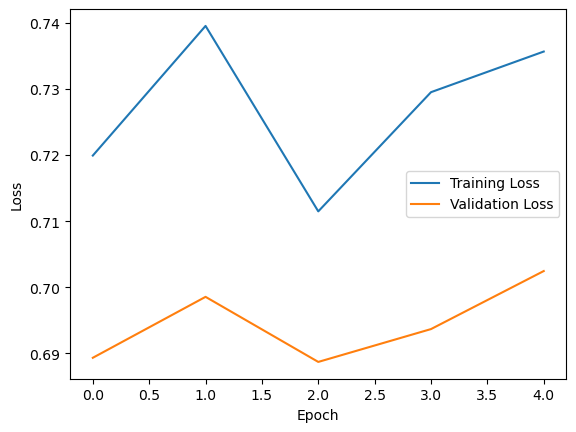

In [21]:
# Training loop
train_losses = []
validation_losses = []
model=MiniLaneDetectionModel()
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Ensure that target values are within the correct range (e.g., 0 and 1 for binary classification)
        target = target % num_classes  # Adjust this line based on your number of classes

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        validation_loss = 0.0
        for data, target in val_loader:
            # Ensure that target values are within the correct range for validation
            target = target % num_classes  # Adjust this line based on your number of classes

            output = model(data)
            loss = criterion(output, target)
            validation_loss += loss.item()

        train_losses.append(loss.item())
        validation_losses.append(validation_loss / len(val_loader))

        print(f"Epoch {epoch + 1}, Training Loss: {loss.item()}, Validation Loss: {validation_loss / len(val_loader)}")

# Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

This code evaluates the model on the test set, calculating the total loss and accuracy. Make sure to adjust the target range transformation based on your specific number of classes. The results are then printed or logged for analysis.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)
# Test the model on the test set
model.eval()

# Variables to store predictions and ground truth
all_predictions = []
all_targets = []

# Variable to store total loss for the entire test set
total_loss = 0.0

with torch.no_grad():
    for data, target in test_loader:
        # Ensure that target values are within the correct range for testing
        target = target % num_classes  # Adjust this line based on your number of classes

        # Move data and target to the device
        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)

        # Accumulate total loss
        total_loss += loss.item()

        # Store predictions and targets
        all_predictions.append(output.argmax(dim=1))  # Assuming a classification model
        all_targets.append(target)

# Concatenate predictions and targets along the batch dimension
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate performance metrics (e.g., accuracy)
correct_predictions = (all_predictions == all_targets).sum().item()
total_samples = all_targets.numel()
accuracy = correct_predictions / total_samples

# Print or log the results
print(f"Performance on Test Set - Accuracy: {accuracy:.4f}")
print(f"Total Loss on Test Set: {total_loss:.4f}")


Performance on Test Set - Accuracy: 0.6842
Total Loss on Test Set: 2.0240


In [25]:
save_path = "lane_detection_model.pth"  # You can customize the path and filename
torch.save(model.state_dict(), save_path)

print(f"Model saved at: {save_path}")

Model saved at: lane_detection_model.pth


This code defines a Gradio interface where users can input an image, and the model will segment the lanes and provide the result as an output image. Users can interact with this interface to see real-time results.

In [26]:
import torch
import gradio as gr
from torchvision import transforms
from PIL import Image
import numpy as np

# Define the path to your saved model checkpoint
checkpoint_path = 'lane_detection_model.pth'

# Load the saved model
model = MiniLaneDetectionModel()
model.load_state_dict(torch.load(checkpoint_path))
model.eval()

# Define the transform for preprocessing the input image
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Define the Gradio function for segmentation
import torch
import gradio as gr
from torchvision import transforms
from PIL import Image
import numpy as np

# ... (same as before)

# Define the Gradio function for segmentation
def segment_lanes(image):
    # Apply the transform to the input image
    input_image = Image.fromarray(image.astype('uint8'), 'RGB')
    input_tensor = transform(input_image)
    input_batch = input_tensor.unsqueeze(0)  # Add a batch dimension

    # Forward pass to obtain the segmentation mask
    with torch.no_grad():
        segmentation_mask = model(input_batch)

    # Assuming your model produces a tensor representing the segmentation mask,
    # you may want to apply a threshold to convert it into a binary mask (lane or not lane)
    threshold = 0.5  # Adjust this threshold as needed
    binary_mask = (segmentation_mask > threshold).float()

    # Convert PyTorch tensor to NumPy array for compatibility
    binary_mask_np = binary_mask.squeeze().cpu().numpy()

    # Ensure that binary_mask_np is 2D (not 3D)
    binary_mask_np = binary_mask_np[0] if len(binary_mask_np.shape) == 3 else binary_mask_np

    # Resize the binary_mask_np to match the shape of the input image
    binary_mask_np = np.resize(binary_mask_np, image.shape[:2])

    # Create a colored overlay using the original image and the binary mask
    segmented_image = np.zeros_like(image, dtype=np.uint8)
    segmented_image[:, :, 0] = (image[:, :, 0] * (1 - binary_mask_np)).astype(np.uint8)  # Red channel
    segmented_image[:, :, 1] = (image[:, :, 1] * (1 - binary_mask_np)).astype(np.uint8)  # Green channel
    segmented_image[:, :, 2] = (image[:, :, 2] + 255 * binary_mask_np).astype(np.uint8)  # Blue channel

    return segmented_image

# Create the Gradio interface
iface = gr.Interface(fn=segment_lanes, inputs="image", outputs="image")

# Launch the Gradio interface
iface.launch()

Flattened Size: 2048
Running on local URL:  http://127.0.0.1:7872

To create a public link, set `share=True` in `launch()`.
